## Dataset exploration

In [1]:
!pip install scikeras
!pip install tensorflow scikit-learn

!pip install -U scikit-learn==1.5.1 scikeras==0.13.0

import pandas as pd
import matplotlib.pyplot as plt
from numpy import*
from sklearn import*


# sklearn 10FCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split


# Keras
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 67.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.1 which is incompatible.


In [2]:
!unzip /content/drive/MyDrive/Dublin_study/DL/covid.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [3]:
from PIL import Image
import glob

Mask folder that is present in each class folder will not be used as it is for segmentation tasks and we are only doing classification

**Class	Description**
COVID-19:	X-ray with COVID-19.
Normal: no infection.


Lung Opacity	Non-COVID infections showing opacities in lungs (e.g. “lung infection” / non-COVID pneumonia)

Viral Pneumonia	Pneumonia caused by viruses (non-COVID viruses)

In [4]:
import glob

image_count = glob.glob('/content/COVID-19_Radiography_Dataset/COVID/images/*.png')
print("Total images with covid label:", len(image_count))

Total images with covid label: 3616


In [5]:
import os
from collections import Counter
# confirming all files in folder are .png no other image file type
folder = "/content/COVID-19_Radiography_Dataset/COVID/images"

extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(folder)]
counts = Counter(extensions)

print(counts)


Counter({'.png': 3616})


In [6]:
import glob

image_count = glob.glob('/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/*.png')
print("Total images with Lung opacity (non-covid) label:", len(image_count))

Total images with Lung opacity (non-covid) label: 6012


In [7]:
import os
from collections import Counter
# confirming all files in folder are .png no other image file type
folder = "/content/COVID-19_Radiography_Dataset/Lung_Opacity/images"

extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(folder)]
counts = Counter(extensions)

print(counts)


Counter({'.png': 6012})


In [8]:
import glob

image_count = glob.glob('/content/COVID-19_Radiography_Dataset/Normal/images/*.png')
print("Total images with Normal (no-infection) label:", len(image_count))

Total images with Normal (no-infection) label: 10192


In [9]:
import os
from collections import Counter
# confirming all files in folder are .png no other image file type
folder = "/content/COVID-19_Radiography_Dataset/Normal/images"

extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(folder)]
counts = Counter(extensions)

print(counts)


Counter({'.png': 10192})


In [10]:
import glob

image_count = glob.glob('/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/*.png')
print("Total images with Normal (no-infection) label:", len(image_count))

Total images with Normal (no-infection) label: 1345


In [11]:
import os
from collections import Counter
# confirming all files in folder are .png no other image file type
folder = "/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images"

extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(folder)]
counts = Counter(extensions)

print(counts)


Counter({'.png': 1345})


**clear class imbalance, will address later using techniques from other papers with small dummy model code**

### Image shape and resizing

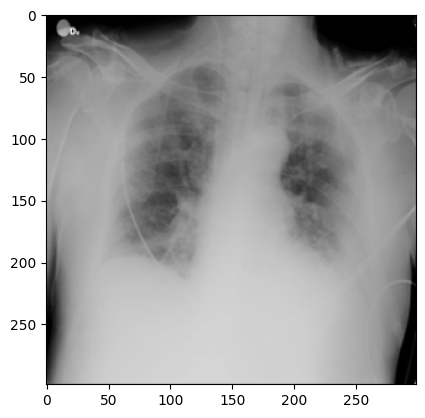

In [12]:
import os
import glob
from PIL import Image

myImage =  Image.open("/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png")


plt.imshow(myImage,cmap = 'gray')
plt.show()

In [13]:
print(myImage.size)

(299, 299)


All images are 399x399 pixels

Source for resizing width and height: https://www.nature.com/articles/s41598-024-61693-0?

"Resizing the images is an essential process to satisfy the requirement of CNN of equally sized input images. In this research, the process of resizing X-ray images has been done to fit all X-ray images to the input size of the used pre-trained CNN models which are VGG19 and EfficientNetB0. Therefore, all images’ versions either full or segmented versions were resized to fit the CNNs input image size which is 224 × 224 pixels"

In [14]:
w = 112 # only for data preprocessing to ease with code
h = 112


X = []
Y=[]

for item in os.listdir("/content/COVID-19_Radiography_Dataset/COVID/images"):
    img_path = os.path.join('/content/COVID-19_Radiography_Dataset/COVID/images',item)
    im = Image.open(img_path)
    img = im.resize((w,h), Image.Resampling.LANCZOS)# the resampling part does antialiasing but package name changed
    img=img.convert('L')
    X.append(img)
    Y.append(0)

newImages_1 = []

for item in os.listdir("/content/COVID-19_Radiography_Dataset/Lung_Opacity/images"):
    img_path = os.path.join('/content/COVID-19_Radiography_Dataset/Lung_Opacity/images', item)
    im = Image.open(img_path)
    img = im.resize((w,h),Image.Resampling.LANCZOS)
    img=img.convert('L')
    X.append(img)
    Y.append(1)

for item in os.listdir("/content/COVID-19_Radiography_Dataset/Normal/images"):
    img_path = os.path.join('/content/COVID-19_Radiography_Dataset/Normal/images', item)
    im = Image.open(img_path)
    img = im.resize((w,h),Image.Resampling.LANCZOS)
    img=img.convert('L')
    X.append(img)
    Y.append(2)

for item in os.listdir("/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images"):
    img_path = os.path.join('/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images', item)
    im = Image.open(img_path)
    img = im.resize((w,h),Image.Resampling.LANCZOS)
    img=img.convert('L')
    X.append(img)
    Y.append(3)

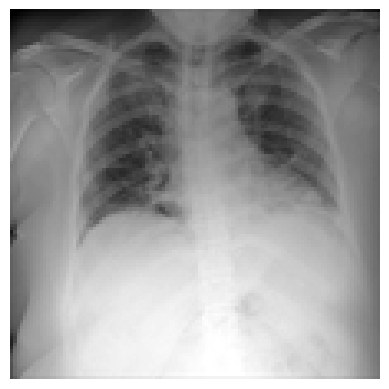

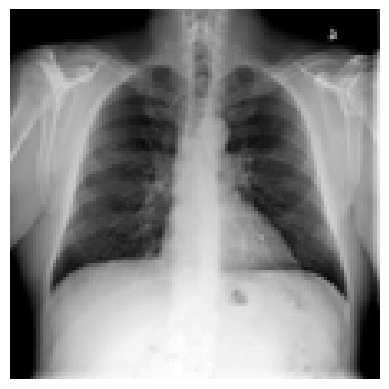

In [15]:
import matplotlib.pyplot as plt


plt.imshow(X[0], cmap="gray")

plt.axis("off")
plt.show()

plt.imshow(X[11000], cmap="gray")
plt.axis("off")
plt.show()


In [16]:
print(len(X))

21165


### Image enhancement code, the same resizing block of code is being reused from above so you only need to run one of them, there is one per image technique or you can use the above one that is the orignial**

Patel et al. (2020)  The models of
interest include BBHE, and RMSHE, an enhanced method that recursively decomposes

proposed pipeline uses clahe to improve image: https://pmc.ncbi.nlm.nih.gov/articles/PMC10728198/


They use CLAHE in a COVID detection pipeline and report improved classifier performance after applying CLAHE as preprocessing. https://pmc.ncbi.nlm.nih.gov/articles/PMC10792799/

they compare  contrast methods and references CLAHE as a competitive baseline for improving CXR classification performance. https://www.sciencedirect.com/science/article/pii/S0030402623002474

tested many histogram equalizations but on brain mri not chest x-ray (still applicable),"  We observe that
BBHE algorithm preserves brightness of the image to a
certain extent but the improved version of BBHE is RMSHE
that gives better results as observed on the basis of various
parameters." https://arxiv.org/abs/2003.06615


shows improvment of performance using both lpt and dwt over just one and over none, in brain mri not in chest x-ray but still medical so worth testing https://www.mdpi.com/2227-9032/10/9/1801

Shows that LPT + similar wavelet transformation (DTCWT) are robust against rotation & scaling  https://pubmed.ncbi.nlm.nih.gov/37112182/



###   BBHE
https://pypi.org/project/image-enhancement/

In [21]:
!pip install image-enhancement

  Preparing metadata (setup.py) ... done
  Created wheel for image-enhancement: filename=image_enhancement-0.2.1-py3-none-any.whl size=13356 sha256=b9696700371eb7674978be43f9c4a278ecab69d7a6dc22b435d0f9ca204111fd
  Stored in directory: /root/.cache/pip/wheels/75/fc/8b/0c08f18c66770ed1e7b5ec3482f1ede13af3054c9f30ccaa03
Successfully built image-enhancement


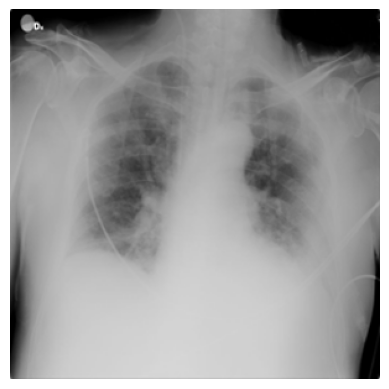

shape of image after bbhe: (112, 112)


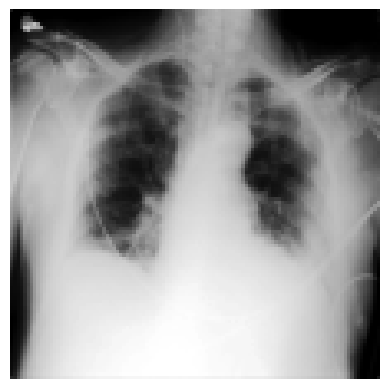

In [30]:
import os
import numpy as np
from skimage.transform import resize
import cv2 as cv
from image_enhancement import image_enhancement

def load_bbhe_one_image(impath, newsize=112):
    # Load image with OpenCV (BGR)
    input_image = cv.imread(impath)

    # Apply BBHE (HSV-based enhancement)
    ie = image_enhancement.IE(input_image, 'HSV')
    output_image = ie.BBHE()

    # Convert BBHE result to numpy & grayscale
    output_image = cv.cvtColor(output_image, cv.COLOR_BGR2GRAY)

    # Resize to desired size
    output_image = resize(output_image, (newsize, newsize),
                          preserve_range=True)

    return output_image.astype("float32")

    # Example usage
normal = cv.imread("/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png")

import matplotlib.pyplot as plt

plt.imshow(normal, cmap='gray') # Displaying in grayscale
plt.axis('off') # Hide axis
plt.show()

one = load_bbhe_one_image("/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png")
print("shape of image after bbhe:",one.shape)

plt.imshow(one, cmap='gray') # Displaying in grayscale
plt.axis('off') # Hide axis
plt.show()

In [ ]:
w = 112
h = 112

X = []
Y = []

# COVID class
for item in os.listdir("/content/COVID-19_Radiography_Dataset/COVID/images"):
    path = f"/content/COVID-19_Radiography_Dataset/COVID/images/{item}"
    img = load_bbhe_one_image(path, newsize=w)
    X.append(img)
    Y.append(0)

# Lung Opacity
for item in os.listdir("/content/COVID-19_Radiography_Dataset/Lung_Opacity/images"):
    path = f"/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/{item}"
    img = load_bbhe_one_image(path, newsize=w)
    X.append(img)
    Y.append(1)

# Normal
for item in os.listdir("/content/COVID-19_Radiography_Dataset/Normal/images"):
    path = f"/content/COVID-19_Radiography_Dataset/Normal/images/{item}"
    img = load_bbhe_one_image(path, newsize=w)
    X.append(img)
    Y.append(2)

# Viral Pneumonia
for item in os.listdir("/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images"):
    path = f"/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/{item}"
    img = load_bbhe_one_image(path, newsize=w)
    X.append(img)
    Y.append(3)

### RMSHE (same package as bbhe)

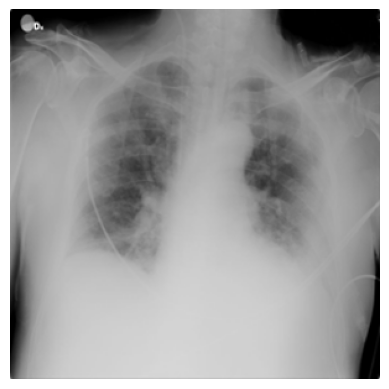

shape of image after rmshe: (112, 112)


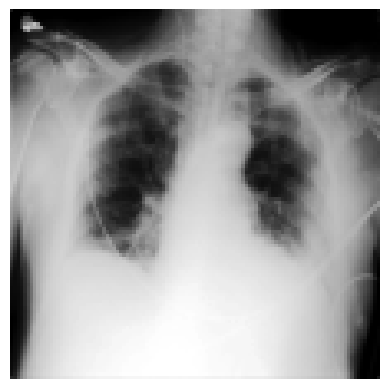

In [29]:
import numpy as np
from skimage.transform import resize
import cv2 as cv
from image_enhancement import image_enhancement

def load_rmshe_one_image(impath, newsize=112):
    # Load image with OpenCV (BGR)
    input_image = cv.imread(impath)

    # Apply RMSHE enhancement (HSV-based)
    ie = image_enhancement.IE(input_image, 'HSV')
    output_image = ie.RMSHE(recursive=True)

    # Convert to grayscale
    output_image = cv.cvtColor(output_image, cv.COLOR_BGR2GRAY)

    # Resize to desired size
    output_image = resize(output_image, (newsize, newsize),
                          preserve_range=True)

    return output_image.astype("float32")


    # Example usage
normal = cv.imread("/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png")

import matplotlib.pyplot as plt

plt.imshow(normal, cmap='gray') # Displaying in grayscale
plt.axis('off') # Hide axis
plt.show()

one = load_rmshe_one_image("/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png")
print("shape of image after rmshe:",one.shape)

plt.imshow(one, cmap='gray') # Displaying in grayscale
plt.axis('off') # Hide axis
plt.show()

In [ ]:
w = 112
h = 112

X = []
Y = []

# COVID class
for item in os.listdir("/content/COVID-19_Radiography_Dataset/COVID/images"):
    path = f"/content/COVID-19_Radiography_Dataset/COVID/images/{item}"
    img = load_rmshe_one_image(path, newsize=w)
    X.append(img)
    Y.append(0)

# Lung Opacity
for item in os.listdir("/content/COVID-19_Radiography_Dataset/Lung_Opacity/images"):
    path = f"/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/{item}"
    img = load_rmshe_one_image(path, newsize=w)
    X.append(img)
    Y.append(1)

# Normal
for item in os.listdir("/content/COVID-19_Radiography_Dataset/Normal/images"):
    path = f"/content/COVID-19_Radiography_Dataset/Normal/images/{item}"
    img = load_rmshe_one_image(path, newsize=w)
    X.append(img)
    Y.append(2)

# Viral Pneumonia
for item in os.listdir("/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images"):
    path = f"/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/{item}"
    img = load_rmshe_one_image(path, newsize=w)
    X.append(img)
    Y.append(3)

### CLAHE
https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html

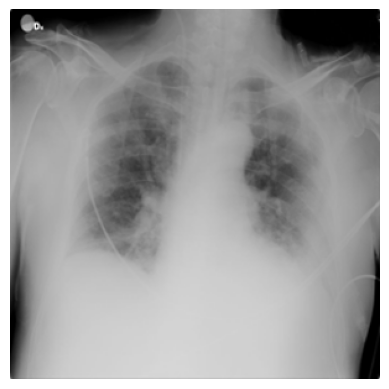

shape of image after clahe: (112, 112)


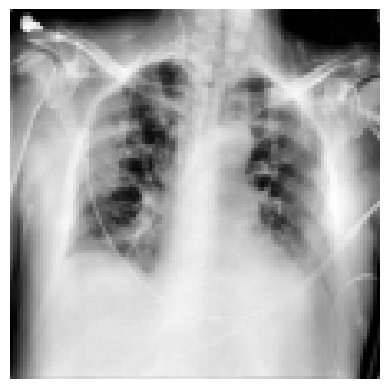

In [31]:
import cv2 as cv
import numpy as np
from skimage.transform import resize

def load_clahe_one_image(impath, newsize=112):

    img = cv.imread(impath, cv.IMREAD_GRAYSCALE)


    clahe = cv.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))

    # Apply CLAHE
    img_clahe = clahe.apply(img)

    # Resize to model size
    img_clahe = resize(img_clahe, (newsize, newsize), preserve_range=True)

    return img_clahe.astype("float32")


# Example usage
normal = cv.imread("/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png")

import matplotlib.pyplot as plt

plt.imshow(normal, cmap='gray') # Displaying in grayscale
plt.axis('off') # Hide axis
plt.show()

one = load_clahe_one_image("/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png")
print("shape of image after clahe:",one.shape)

plt.imshow(one, cmap='gray') # Displaying in grayscale
plt.axis('off') # Hide axis
plt.show()

In [ ]:
w = 112
h = 112

X = []
Y = []

# COVID class
for item in os.listdir("/content/COVID-19_Radiography_Dataset/COVID/images"):
    path = f"/content/COVID-19_Radiography_Dataset/COVID/images/{item}"
    img = load_clahe_one_image(path, newsize=w)
    X.append(img)
    Y.append(0)

# Lung Opacity
for item in os.listdir("/content/COVID-19_Radiography_Dataset/Lung_Opacity/images"):
    path = f"/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/{item}"
    img = load_clahe_one_image(path, newsize=w)
    X.append(img)
    Y.append(1)

# Normal
for item in os.listdir("/content/COVID-19_Radiography_Dataset/Normal/images"):
    path = f"/content/COVID-19_Radiography_Dataset/Normal/images/{item}"
    img = load_clahe_one_image(path, newsize=w)
    X.append(img)
    Y.append(2)

# Viral Pneumonia
for item in os.listdir("/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images"):
    path = f"/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/{item}"
    img = load_clahe_one_image(path, newsize=w)
    X.append(img)
    Y.append(3)


### LPT (LOG-POLAR TRANSFORMATION) and DWT (DISCRETE WAVELET TRANSFOR)


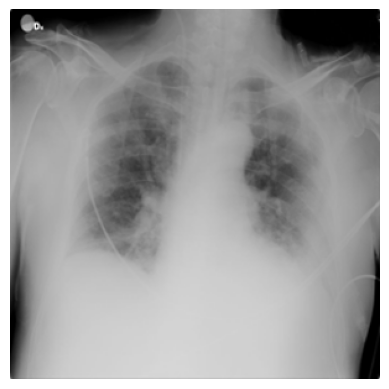

shape of image after clahe: (112, 112)


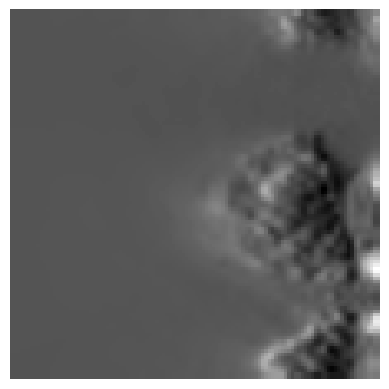

In [14]:
from skimage.io import imread
from skimage.transform import resize, warp_polar
from skimage.color import rgb2gray
import numpy as np
import pywt
import cv2 as cv

def load_lpt_dwt_one_image(impath, newsize=112):
    """
    LPT + DWT Image Enhancement
    Steps:
      1. Read image
      2. Convert to grayscale if needed
      3. Resize to square
      4. Apply Log-Polar Transform
      5. Apply DWT (Haar)
      6. Extract horizontal detail band
      7. Resize detail subband back to newsize x newsize
    """

    # Load the image
    im = imread(impath)

    # Convert color → grayscale
    if len(im.shape) == 3 and im.shape[2] == 3:
        im = rgb2gray(im)
    elif len(im.shape) != 2:
        raise ValueError("Unsupported image format")

    # Resize
    im = resize(im, (newsize, newsize))

    # Log-Polar Transform
    im = warp_polar(
        im,
        radius=newsize/2,
        output_shape=(newsize, newsize),
        scaling='log'
    )

    # Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec2(im, wavelet="haar", level=1)

    # Extract horizontal detail subband
    horizontal_detail = coeffs[1][1]

    # Resize detail band to final size
    im = resize(horizontal_detail, (newsize, newsize))

    return im


# Example usage
normal = cv.imread("/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png")

import matplotlib.pyplot as plt

plt.imshow(normal, cmap='gray') # Displaying in grayscale
plt.axis('off') # Hide axis
plt.show()

one = load_lpt_dwt_one_image("/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png")
print("shape of image after clahe:",one.shape)

plt.imshow(one, cmap='gray') # Displaying in grayscale
plt.axis('off') # Hide axis
plt.show()

In [ ]:
w = 112
h = 112

X = []
Y = []

# COVID class
for item in os.listdir("/content/COVID-19_Radiography_Dataset/COVID/images"):
    path = f"/content/COVID-19_Radiography_Dataset/COVID/images/{item}"
    img = load_lpt_dwt_one_image(path, newsize=w)
    X.append(img)
    Y.append(0)

# Lung Opacity
for item in os.listdir("/content/COVID-19_Radiography_Dataset/Lung_Opacity/images"):
    path = f"/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/{item}"
    img = load_lpt_dwt_one_image(path, newsize=w)
    X.append(img)
    Y.append(1)

# Normal
for item in os.listdir("/content/COVID-19_Radiography_Dataset/Normal/images"):
    path = f"/content/COVID-19_Radiography_Dataset/Normal/images/{item}"
    img = load_lpt_dwt_one_image(path, newsize=w)
    X.append(img)
    Y.append(2)

# Viral Pneumonia
for item in os.listdir("/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images"):
    path = f"/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/{item}"
    img = load_lpt_dwt_one_image(path, newsize=w)
    X.append(img)
    Y.append(3)


### Continuation after image enhancement techniques

NP array Conversion

In [17]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten


import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from PIL import Image
import glob

In [18]:
# Convert to NP array
X = np.array(X)


# reshape to be [samples][channels][width][height]
X = X.reshape(X.shape[0], w, h, 1).astype('float32')

# Normalize the data
X = X /255

# one hot encode outputs
Y = np.array(Y)

# randomize the data set - numpy arrays
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
Y = Y[randomize]


Y = to_categorical(Y)
num_classes = Y.shape[1]

batch processing and data generator


In [19]:
# Tensorflow 2
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
%matplotlib inline
import time

from PIL import Image
import glob
from sklearn.model_selection import train_test_split


**Steps taken to reduce class imbalance**

1- Implementing class weighting

2- stratified sampling

3- data augmentation only on training not validation

papers:

1- https://pmc.ncbi.nlm.nih.gov/articles/PMC9422401/ they applied a class-weighted categorical cross-entropy loss and also data augmentation on only training . Class weights was best perfroming

2- https://www.nature.com/articles/s41598-023-45532-2 similar yet slightly different data augmentation

3- https://pubmed.ncbi.nlm.nih.gov/34305440/ did data augmentation as part of training pipeline so training only

4- https://pmc.ncbi.nlm.nih.gov/articles/PMC8907145/? did data augmentation

5- https://www.mdpi.com/1424-8220/23/4/2333 for stratified sampling



Ethical reason to not do oversampling in medical field:
https://pmc.ncbi.nlm.nih.gov/articles/PMC10789107/

Paper argues that When synthetic images are generated, there is a risk that they contain visual patterns that do not correspond to real medical pathology. A model might learn these artifacts instead of actual COVID-19 or pneumonia features which could lead it to perfrom "well" but fail on real patients.A radiologist must inspect samples and validate that they are medically sound to use as training

In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
# fix random seed
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)



# stratified sampling done
Y_int = np.argmax(Y, axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, stratify=Y_int, random_state=1
)


# compute class weights
y_train_int = np.argmax(Y_train, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights = {i: w for i, w in enumerate(class_weights)}

print("Class weights:", class_weights)

# Augmentation for TRAINING ONLY
train_datagen = ImageDataGenerator(
    samplewise_center=True,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# 2. NO AUGMENTATION for validation
val_datagen = ImageDataGenerator()

train_datagen.fit(X_train)

train_batches = train_datagen.flow(X_train, Y_train, batch_size=32)
val_batches   = val_datagen.flow(X_val, Y_val, batch_size=32)


Class weights: {0: np.float64(1.4631870031109575), 1: np.float64(0.8802245789145352), 2: np.float64(0.5191317144959529), 3: np.float64(3.934014869888476)}


**Please note the class_weight hyperparameter in the model**

In [ ]:
# dummy model
modelC = Sequential([
    Conv2D(32, (3, 3), strides=1, padding="valid",
           input_shape=(w, h, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), padding="valid"),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

modelC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# fit with CLASS WEIGHTS
history = modelC.fit(
    train_batches,
    validation_data=val_batches,
    epochs=20,
    verbose=1,
    class_weight=class_weights # IMPORTANT
)

# accuracy plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()